# Importing useful libraries and checking versions

In [3]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from PIL import Image

# import some common detectron2 utilities
import logging
import torch
from collections import OrderedDict
import detectron2
from pycocotools.coco import COCO 
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

In [8]:
# Checking versions
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  2.1 ; cuda:  cpu


"nvcc" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## Data registration and sample showing

In [5]:
# We register train/valid/test datasets
register_coco_instances("blood_cells_train", {}, f"./images/train/_annotations.coco.json", f"./images/train/")
register_coco_instances("blood_cells_valid", {}, f"./images/valid/_annotations.coco.json", f"./images/valid/")
register_coco_instances("blood_cells_test", {}, f"./images/test/_annotations.coco.json", f"./images/test/")

WARNING [08/29 10:26:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/29 10:26:06 d2.data.datasets.coco]: Loaded 9951 images in COCO format from ./images/train/_annotations.coco.json
WARNING [08/29 10:26:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/29 10:26:06 d2.data.datasets.coco]: Loaded 803 images in COCO format from ./images/valid/_annotations.coco.json
WARNING [08/29 10:26:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/29 10:26:06 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json


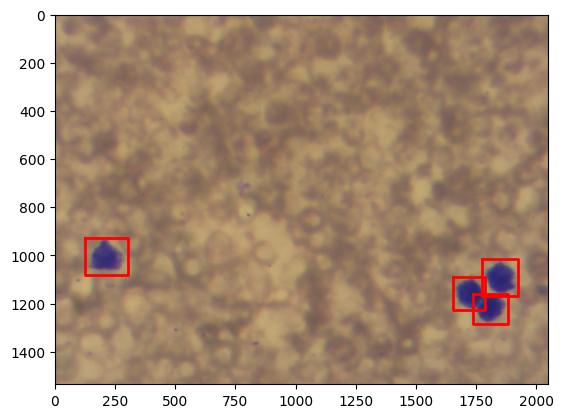

In [7]:
# Show random sample with some bboxes from train dataset
dataset_train = DatasetCatalog.get("blood_cells_train")
dataset_valid = DatasetCatalog.get("blood_cells_valid")
dataset_test = DatasetCatalog.get("blood_cells_test")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

## Configure models hyperparameters and augmentation for effective training

In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("blood_cells_train",)
cfg.DATASETS.VALID = ("blood_cells_valid",)
cfg.DATASETS.TEST = ("blood_cells_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.MAX_ITER = 2500 
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12 
cfg.TEST.EVAL_PERIOD = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [11]:
# Data Augmentation
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
augmentation = [
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
    T.RandomRotation(angle=[0, 90, 180, 270]),
]

# Apply augmentations to the dataset
train_loader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=augmentation))

[08/23 20:01:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomFlip(prob=0.5), RandomFlip(prob=0.5, horizontal=False, vertical=True), RandomRotation(angle=[0, 90, 180, 270])]
WARNING [08/23 20:01:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:01:40 d2.data.datasets.coco]: Loaded 9951 images in COCO format from ./images/train/_annotations.coco.json
[08/23 20:01:41 d2.data.build]: Removed 766 images with no usable annotations. 9185 images left.
[08/23 20:01:41 d2.data.build]: Distribution of instances among all 12 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  BloodCells   | 0            | PLT_agregat.. | 1            |  PLT_bitmap   | 30113        |
| RBC_Normal_.. | 3            | WBC_BAS_bit.. | 26           | WBC_EOS_

## Long training step

In [13]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/23 20:01:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [08/23 20:01:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:01:57 d2.data.datasets.coco]: Loaded 9951 images in COCO format from ./images/train/_annotations.coco.json
[08/23 20:01:57 d2.data.build]: Removed 766 images with no usable annotations. 9185 images left.
[08/23 20:01:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/23 20:01:57 d2.data.build]: Using training sampler TrainingSampler
[08/23 20:01:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:01:57 d2.data.common]: Serializing 9185 elements to byte tensors and concatenating them all ...
[08/23 20:01:57 d2.data.common]: Serialized dataset takes 13.84 MiB
[08/23 20:01:57 d2.data.build]: Making batched data loader with batch_siz

model_final_f10217.pkl: 178MB [00:22, 7.99MB/s]                                                                        
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (13, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (13,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (48, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (48,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.

[08/23 20:02:20 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)


WARNING [08/23 20:03:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:03:52 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 20:03:52 d2.data.build]: Distribution of instances among all 12 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  BloodCells   | 0            | PLT_agregat.. | 0            |  PLT_bitmap   | 35           |
| RBC_Normal_.. | 0            | WBC_BAS_bit.. | 0            | WBC_EOS_bit.. | 5            |
| WBC_LYM_bit.. | 126          | WBC_MONO_bi.. | 0            | WBC_NEU_bit.. | 42           |
| artifact_bi.. | 12           | destroyed c.. | 13           | divided cel.. | 2            |
|               |              |               |              |               |              |


[08/23 20:13:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:13:44 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 20:13:44 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 20:13:44 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 20:15:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:15:03 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 20:15:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 20:15:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:15:0

[08/23 20:25:09 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 20:25:09 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 20:25:09 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 20:26:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:26:16 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 20:26:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 20:26:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:26:16 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 20:26:16 d2.data.comm

[08/23 20:36:14 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 20:36:14 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 20:37:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:37:26 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 20:37:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 20:37:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:37:26 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 20:37:26 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 20:37:26 d2.engine.defaults]: No evaluator found. 

WARNING [08/23 20:48:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 20:48:20 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 20:48:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 20:48:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:48:20 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 20:48:20 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 20:48:20 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 20:49:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/23 20:59:50 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 20:59:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 20:59:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 20:59:50 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 20:59:50 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 20:59:50 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 21:01:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 21:01:03 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 21:01:03 d2

[08/23 21:10:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 21:10:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 21:10:16 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 21:10:16 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 21:10:16 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 21:11:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 21:11:27 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 21:11:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/23 21:20:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 21:20:34 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 21:20:34 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 21:20:34 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 21:21:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 21:21:43 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 21:21:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 21:21:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 21:21:4

[08/23 21:31:47 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 21:31:47 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 21:31:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 21:33:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 21:33:06 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 21:33:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 21:33:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 21:33:06 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 21:33:06 d2.data.comm

[08/23 21:44:03 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 21:44:03 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 21:45:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 21:45:26 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 21:45:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 21:45:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 21:45:26 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 21:45:26 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 21:45:26 d2.engine.defaults]: No evaluator found. 

WARNING [08/23 21:58:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 21:58:19 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 21:58:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 21:58:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 21:58:19 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 21:58:19 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 21:58:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 21:59:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/23 22:10:33 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 22:10:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 22:10:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 22:10:33 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 22:10:33 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 22:10:33 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 22:11:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 22:11:51 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 22:11:51 d2

[08/23 22:23:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 22:23:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 22:23:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/23 22:23:28 d2.utils.events]:  eta: 23:54:23  iter: 219  total_loss: 1.292  loss_cls: 0.3739  loss_box_reg: 0.4093  loss_mask: 0.4201  loss_rpn_cls: 0.05312  loss_rpn_loc: 0.04207    time: 38.3298  last_time: 48.0027  data_time: 0.0166  last_data_time: 0.0362   lr: 0.00010989  
WARNING [08/23 22:25:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 22:25:05 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 22:25:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_si

[08/23 22:36:16 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 22:36:16 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 22:37:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 22:37:33 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 22:37:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 22:37:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 22:37:33 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 22:37:33 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 22:37:33 d2.engine.defaults]: No evaluator found. 

WARNING [08/23 22:50:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 22:50:38 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 22:50:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 22:50:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 22:50:38 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 22:50:38 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 22:50:38 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 22:51:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/23 23:03:28 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 23:03:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 23:03:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 23:03:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 23:03:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 23:03:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 23:04:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 23:04:53 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 23:04:53 d2

[08/23 23:16:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 23:16:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 23:16:01 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 23:16:01 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 23:16:01 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 23:17:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 23:17:22 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 23:17:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/23 23:28:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 23:28:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 23:28:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 23:28:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 23:29:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 23:29:54 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 23:29:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 23:29:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 23:29:5

[08/23 23:40:24 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 23:40:24 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 23:40:24 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 23:41:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 23:41:52 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 23:41:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 23:41:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 23:41:52 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 23:41:52 d2.data.comm

[08/23 23:53:25 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 23:53:25 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/23 23:54:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/23 23:54:45 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/23 23:54:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 23:54:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/23 23:54:45 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/23 23:54:45 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/23 23:54:45 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 00:07:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 00:07:47 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:07:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 00:07:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 00:07:47 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 00:07:47 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 00:07:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 00:09:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 00:19:47 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:19:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 00:19:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 00:19:47 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 00:19:47 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 00:19:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 00:21:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 00:21:12 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:21:12 d2

[08/24 00:32:09 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:32:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 00:32:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 00:32:09 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 00:32:09 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 00:32:09 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 00:33:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 00:33:29 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:33:29 d2

[08/24 00:44:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 00:44:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 00:44:11 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 00:44:11 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 00:44:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 00:45:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 00:45:31 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:45:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 00:56:10 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 00:56:10 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 00:56:10 d2.utils.events]:  eta: 22:14:19  iter: 439  total_loss: 0.8956  loss_cls: 0.2097  loss_box_reg: 0.2558  loss_mask: 0.3338  loss_rpn_cls: 0.04317  loss_rpn_loc: 0.06218    time: 39.9544  last_time: 38.9434  data_time: 0.0226  last_data_time: 0.0074   lr: 0.00021978  
WARNING [08/24 00:57:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 00:57:25 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 00:57:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 00:57:25 d2.data.common]: Serializing the dataset using: <class

WARNING [08/24 01:09:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 01:09:10 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 01:09:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 01:09:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 01:09:11 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 01:09:11 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 01:09:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 01:09:11 d2.utils.events]:  eta: 22:01:47  iter: 459  total_loss: 1.026  loss_cls: 0.2498  loss_box_reg: 0.3079  loss_mask: 0

[08/24 01:20:39 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 01:20:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 01:20:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 01:20:39 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 01:20:39 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 01:20:39 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 01:21:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 01:21:57 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 01:21:57 d2

[08/24 01:32:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 01:32:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 01:32:18 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 01:32:18 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 01:32:18 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 01:33:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 01:33:41 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 01:33:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 01:44:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 01:44:24 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 01:44:24 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 01:44:24 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 01:45:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 01:45:38 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 01:45:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 01:45:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 01:45:3

[08/24 01:56:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 01:56:21 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 01:56:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 01:57:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 01:57:44 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 01:57:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 01:57:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 01:57:45 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 01:57:45 d2.data.comm

[08/24 02:07:43 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 02:07:43 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 02:08:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 02:08:55 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 02:08:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 02:08:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 02:08:55 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 02:08:55 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 02:08:56 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 02:20:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 02:20:21 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 02:20:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 02:20:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 02:20:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 02:20:21 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 02:20:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 02:21:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 02:32:08 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 02:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 02:32:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 02:32:08 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 02:32:08 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 02:32:08 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 02:33:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 02:33:29 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 02:33:29 d2

[08/24 02:43:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 02:43:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 02:43:54 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 02:43:54 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 02:43:54 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 02:45:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 02:45:34 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 02:45:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 02:56:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 02:56:14 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 02:56:14 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 02:56:14 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 02:57:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 02:57:29 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 02:57:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 02:57:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 02:57:2

[08/24 03:08:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 03:08:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 03:08:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 03:10:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 03:10:07 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 03:10:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 03:10:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 03:10:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 03:10:07 d2.data.comm

WARNING [08/24 06:20:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 06:20:18 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 06:20:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 06:20:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 06:20:18 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 06:20:18 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 06:20:18 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 06:21:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 06:32:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 06:32:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 06:32:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 06:32:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 06:32:28 d2.utils.events]:  eta: 19:36:57  iter: 679  total_loss: 0.9228  loss_cls: 0.2332  loss_box_reg: 0.2476  loss_mask: 0.3165  loss_rpn_cls: 0.05048  loss_rpn_loc: 0.05636    time: 55.5529  last_time: 35.3104  data_time: 0.0211  last_data_time: 0.0106   lr: 0.00033966  
WARNING [08/24 06:33:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 06:33:46 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 06:33:46 d2.data.dat

[08/24 06:44:16 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 06:44:16 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 06:44:16 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 06:45:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 06:45:21 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 06:45:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 06:45:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 06:45:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 06:45:21 d2.data.comm

[08/24 06:55:33 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 06:55:33 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 06:57:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 06:57:09 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 06:57:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 06:57:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 06:57:09 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 06:57:09 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 06:57:09 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 07:08:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 07:08:43 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 07:08:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 07:08:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 07:08:43 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 07:08:43 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 07:08:43 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 07:10:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 07:20:47 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 07:20:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 07:20:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 07:20:47 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 07:20:47 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 07:20:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 07:22:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 07:22:18 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 07:22:18 d2

[08/24 07:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 07:32:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 07:32:52 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 07:32:52 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 07:32:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 07:34:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 07:34:20 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 07:34:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 07:45:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 07:45:16 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 07:45:16 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 07:45:16 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 07:46:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 07:46:44 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 07:46:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 07:46:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 07:46:4

[08/24 07:57:15 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 07:57:15 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 07:57:15 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 07:58:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 07:58:33 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 07:58:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 07:58:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 07:58:33 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 07:58:33 d2.data.comm

[08/24 08:08:55 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 08:08:55 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 08:10:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 08:10:22 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 08:10:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 08:10:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 08:10:22 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 08:10:22 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 08:10:22 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 08:22:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 08:22:38 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 08:22:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 08:22:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 08:22:38 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 08:22:38 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 08:22:38 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 08:23:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 08:36:07 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 08:36:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 08:36:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 08:36:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 08:36:07 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 08:36:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 08:37:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 08:37:43 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 08:37:43 d2

[08/24 08:50:07 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 08:50:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 08:50:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 08:50:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 08:50:07 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 08:50:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 08:51:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 08:51:35 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 08:51:35 d2

[08/24 09:02:48 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 09:02:48 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 09:02:48 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 09:02:48 d2.utils.events]:  eta: 17:18:00  iter: 899  total_loss: 0.7326  loss_cls: 0.1911  loss_box_reg: 0.1916  loss_mask: 0.2546  loss_rpn_cls: 0.03199  loss_rpn_loc: 0.02686    time: 51.9682  last_time: 40.9535  data_time: 0.0195  last_data_time: 0.0091   lr: 0.00044955  
WARNING [08/24 09:04:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 09:04:04 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 09:04:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_s

[08/24 09:16:31 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 09:16:31 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 09:17:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 09:17:56 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 09:17:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 09:17:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 09:17:56 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 09:17:56 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 09:17:56 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 09:31:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 09:31:31 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 09:31:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 09:31:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 09:31:31 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 09:31:31 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 09:31:31 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 09:33:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 09:44:33 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 09:44:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 09:44:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 09:44:33 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 09:44:33 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 09:44:33 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 09:45:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 09:45:56 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 09:45:56 d2

[08/24 09:58:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 09:58:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 09:58:05 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 09:58:05 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 09:58:05 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 09:59:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 09:59:35 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 09:59:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 10:11:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 10:11:31 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 10:11:31 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 10:11:31 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 10:12:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 10:12:57 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 10:12:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 10:12:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 10:12:5

[08/24 10:24:44 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 10:24:44 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 10:24:44 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 10:26:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 10:26:16 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 10:26:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 10:26:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 10:26:16 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 10:26:16 d2.data.comm

[08/24 10:38:24 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 10:38:24 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 10:39:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 10:39:59 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 10:39:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 10:39:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 10:39:59 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 10:39:59 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 10:39:59 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 10:53:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 10:53:19 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 10:53:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 10:53:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 10:53:19 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 10:53:19 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 10:53:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 10:54:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 11:07:00 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 11:07:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 11:07:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 11:07:01 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 11:07:01 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 11:07:01 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 11:08:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 11:08:31 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 11:08:31 d2

[08/24 11:20:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 11:20:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 11:20:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 11:20:07 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 11:20:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 11:21:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 11:21:44 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 11:21:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 11:33:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 11:33:52 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 11:33:52 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 11:33:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 11:35:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 11:35:19 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 11:35:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 11:35:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 11:35:1

[08/24 11:47:50 d2.utils.events]:  eta: 15:36:37  iter: 1119  total_loss: 0.7672  loss_cls: 0.1933  loss_box_reg: 0.211  loss_mask: 0.263  loss_rpn_cls: 0.02591  loss_rpn_loc: 0.02969    time: 50.5809  last_time: 56.3112  data_time: 0.0246  last_data_time: 0.0111   lr: 0.0005  
WARNING [08/24 11:49:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 11:49:04 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 11:49:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 11:49:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 11:49:04 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 11:49:04 d2.data.common]: Serialized dataset takes 0.05 MiB
W

[08/24 12:03:00 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 12:03:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 12:03:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 12:03:00 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 12:03:00 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 12:03:00 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 12:03:00 d2.utils.events]:  eta: 15:25:33  iter: 1139  total_loss: 0.908  loss_cls: 0.2504  loss_box_reg: 0.293  loss_mask: 0.2734  loss_rpn_cls: 0.03244  loss_rpn_loc: 0.0483    time: 50.4902  last_time: 45.2505  data_time: 0.0286  last_data_time: 0.0433   lr: 0

[08/24 12:16:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 12:16:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 12:16:06 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 12:16:06 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 12:16:06 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 12:17:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 12:17:25 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 12:17:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 12:28:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 12:28:56 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 12:28:56 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 12:28:56 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 12:30:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 12:30:27 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 12:30:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 12:30:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 12:30:2

[08/24 12:41:55 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 12:41:55 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 12:41:55 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 12:43:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 12:43:39 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 12:43:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 12:43:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 12:43:39 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 12:43:39 d2.data.comm

[08/24 12:55:01 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 12:55:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 12:56:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 12:56:32 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 12:56:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 12:56:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 12:56:32 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 12:56:32 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 12:56:32 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 13:09:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 13:09:53 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 13:09:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 13:09:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 13:09:53 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 13:09:53 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 13:09:53 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 13:11:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 13:22:38 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 13:22:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 13:22:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 13:22:38 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 13:22:38 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 13:22:38 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 13:24:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 13:24:13 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 13:24:13 d2

[08/24 13:36:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 13:36:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 13:36:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 13:36:21 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 13:36:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 13:37:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 13:37:52 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 13:37:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 13:49:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 13:49:35 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 13:49:35 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 13:49:35 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 13:50:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 13:50:59 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 13:50:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 13:50:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 13:50:5

[08/24 14:03:11 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:03:11 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 14:03:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 14:04:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 14:04:34 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 14:04:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 14:04:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 14:04:34 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:04:34 d2.data.comm

[08/24 14:16:56 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 14:16:56 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 14:18:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 14:18:24 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 14:18:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 14:18:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 14:18:24 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:18:24 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 14:18:24 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 14:31:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 14:31:40 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 14:31:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 14:31:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 14:31:40 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:31:40 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 14:31:40 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 14:33:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 14:45:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 14:45:02 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:45:02 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 14:45:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 14:45:02 d2.utils.events]:  eta: 13:11:00  iter: 1359  total_loss: 0.8569  loss_cls: 0.2407  loss_box_reg: 0.2532  loss_mask: 0.2678  loss_rpn_cls: 0.03036  loss_rpn_loc: 0.04063    time: 49.4562  last_time: 36.9815  data_time: 0.0284  last_data_time: 0.0293   lr: 0.0005  
WARNING [08/24 14:46:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 14:46:33 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 14:46:33 d2.data.datase

[08/24 14:57:18 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:57:18 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 14:57:18 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 14:58:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 14:58:44 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 14:58:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 14:58:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 14:58:44 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 14:58:44 d2.data.comm

[08/24 15:10:54 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 15:10:54 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 15:12:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 15:12:29 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 15:12:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 15:12:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 15:12:29 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 15:12:29 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 15:12:29 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 15:25:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 15:25:37 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 15:25:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 15:25:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 15:25:37 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 15:25:37 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 15:25:37 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 15:27:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 15:38:55 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 15:38:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 15:38:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 15:38:55 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 15:38:55 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 15:38:55 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 15:40:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 15:40:10 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 15:40:10 d2

[08/24 15:51:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 15:51:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 15:51:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 15:51:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 15:51:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 15:52:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 15:52:53 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 15:52:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 16:04:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 16:04:29 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 16:04:29 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 16:04:29 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 16:06:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 16:06:05 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 16:06:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 16:06:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 16:06:0

[08/24 16:17:37 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 16:17:37 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 16:17:37 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 16:18:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 16:18:57 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 16:18:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 16:18:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 16:18:57 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 16:18:57 d2.data.comm

[08/24 16:30:45 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 16:30:45 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 16:32:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 16:32:10 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 16:32:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 16:32:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 16:32:10 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 16:32:10 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 16:32:10 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 16:45:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 16:45:27 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 16:45:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 16:45:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 16:45:27 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 16:45:27 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 16:45:27 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 16:46:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 16:59:02 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 16:59:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 16:59:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 16:59:02 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 16:59:02 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 16:59:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 17:00:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 17:00:36 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 17:00:36 d2

[08/24 17:13:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 17:13:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 17:13:02 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 17:13:02 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 17:13:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 17:14:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 17:14:28 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 17:14:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 17:26:27 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 17:26:27 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 17:26:27 d2.utils.events]:  eta: 10:53:38  iter: 1579  total_loss: 0.7499  loss_cls: 0.1896  loss_box_reg: 0.2122  loss_mask: 0.2581  loss_rpn_cls: 0.04261  loss_rpn_loc: 0.03851    time: 48.6877  last_time: 42.5252  data_time: 0.0202  last_data_time: 0.0517   lr: 0.0005  
WARNING [08/24 17:27:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 17:27:58 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 17:27:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 17:27:58 d2.data.common]: Serializing the dataset using: <class 'd

WARNING [08/24 17:41:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 17:41:41 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 17:41:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 17:41:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 17:41:41 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 17:41:41 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 17:41:41 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 17:41:41 d2.utils.events]:  eta: 10:40:20  iter: 1599  total_loss: 0.8002  loss_cls: 0.1919  loss_box_reg: 0.2431  loss_mask:

[08/24 17:54:36 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 17:54:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 17:54:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 17:54:36 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 17:54:36 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 17:54:36 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 17:56:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 17:56:04 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 17:56:04 d2

[08/24 18:07:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 18:07:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 18:07:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 18:07:07 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 18:07:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 18:08:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 18:08:29 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 18:08:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 18:19:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 18:19:58 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 18:19:58 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 18:19:58 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 18:21:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 18:21:23 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 18:21:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 18:21:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 18:21:2

[08/24 18:32:25 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 18:32:25 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 18:32:25 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 18:33:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 18:33:49 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 18:33:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 18:33:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 18:33:49 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 18:33:49 d2.data.comm

[08/24 18:44:57 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 18:44:57 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 18:46:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 18:46:16 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 18:46:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 18:46:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 18:46:16 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 18:46:16 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 18:46:16 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 18:59:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 18:59:21 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 18:59:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 18:59:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 18:59:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 18:59:21 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 18:59:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 19:00:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 19:11:24 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 19:11:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 19:11:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 19:11:24 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 19:11:24 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 19:11:24 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 19:12:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 19:12:46 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 19:12:46 d2

[08/24 19:24:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 19:24:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 19:24:04 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 19:24:04 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 19:24:04 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 19:25:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 19:25:30 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 19:25:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 19:36:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 19:36:17 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 19:36:18 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 19:36:18 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 19:37:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 19:37:44 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 19:37:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 19:37:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 19:37:4

[08/24 19:48:25 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 19:48:25 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 19:48:25 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 19:49:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 19:49:51 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 19:49:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 19:49:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 19:49:51 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 19:49:51 d2.data.comm

WARNING [08/24 20:02:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 20:02:13 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 20:02:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 20:02:13 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 20:02:13 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 20:02:13 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 20:02:13 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 20:03:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 20:14:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 20:14:54 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 20:14:54 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 20:14:54 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 20:14:54 d2.utils.events]:  eta: 8:05:14  iter: 1819  total_loss: 0.7917  loss_cls: 0.2219  loss_box_reg: 0.2494  loss_mask: 0.2444  loss_rpn_cls: 0.02993  loss_rpn_loc: 0.04782    time: 47.8093  last_time: 37.8197  data_time: 0.0285  last_data_time: 0.0365   lr: 0.0005  
WARNING [08/24 20:16:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 20:16:13 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 20:16:13 d2.data.dataset

[08/24 20:27:54 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 20:27:54 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 20:27:54 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 20:29:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 20:29:32 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 20:29:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 20:29:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 20:29:32 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 20:29:32 d2.data.comm

[08/24 20:40:40 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 20:40:40 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 20:42:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 20:42:06 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 20:42:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 20:42:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 20:42:06 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 20:42:06 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 20:42:06 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 20:56:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 20:56:21 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 20:56:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 20:56:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 20:56:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 20:56:21 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 20:56:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 20:57:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 21:09:48 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 21:09:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 21:09:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 21:09:48 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 21:09:48 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 21:09:48 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 21:11:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 21:11:05 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 21:11:05 d2

[08/24 21:22:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 21:22:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 21:22:52 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 21:22:52 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 21:22:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 21:24:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 21:24:19 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 21:24:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 21:35:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 21:35:42 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 21:35:42 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 21:35:42 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 21:37:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 21:37:13 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 21:37:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 21:37:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 21:37:1

[08/24 21:48:32 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 21:48:32 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 21:48:32 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 21:49:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 21:49:54 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 21:49:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 21:49:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 21:49:54 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 21:49:54 d2.data.comm

[08/24 22:01:45 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 22:01:45 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 22:03:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 22:03:04 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 22:03:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 22:03:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 22:03:04 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 22:03:04 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 22:03:04 d2.engine.defaults]: No evaluator found. 

WARNING [08/24 22:15:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 22:15:51 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 22:15:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 22:15:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 22:15:52 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 22:15:52 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 22:15:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 22:17:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/24 22:28:52 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 22:28:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 22:28:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 22:28:52 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 22:28:52 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 22:28:52 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 22:30:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 22:30:17 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 22:30:17 d2

[08/24 22:42:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 22:42:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 22:42:28 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 22:42:28 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 22:42:28 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 22:43:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 22:43:49 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 22:43:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 22:54:58 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 22:54:58 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 22:54:58 d2.utils.events]:  eta: 5:27:29  iter: 2039  total_loss: 0.7301  loss_cls: 0.1812  loss_box_reg: 0.2012  loss_mask: 0.2385  loss_rpn_cls: 0.02153  loss_rpn_loc: 0.04632    time: 47.3515  last_time: 42.0471  data_time: 0.0226  last_data_time: 0.0338   lr: 0.0005  
WARNING [08/24 22:56:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 22:56:18 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 22:56:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 22:56:18 d2.data.common]: Serializing the dataset using: <class 'de

WARNING [08/24 23:09:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 23:09:50 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 23:09:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 23:09:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 23:09:50 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 23:09:50 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 23:09:50 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/24 23:09:50 d2.utils.events]:  eta: 5:13:29  iter: 2059  total_loss: 0.8038  loss_cls: 0.1946  loss_box_reg: 0.2404  loss_mask: 

[08/24 23:23:20 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 23:23:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 23:23:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 23:23:20 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 23:23:20 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 23:23:20 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 23:24:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 23:24:37 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 23:24:37 d2

[08/24 23:36:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 23:36:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 23:36:38 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 23:36:38 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 23:36:38 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 23:38:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 23:38:32 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 23:38:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/24 23:50:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 23:50:26 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/24 23:50:26 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/24 23:50:26 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/24 23:51:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/24 23:51:58 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/24 23:51:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/24 23:51:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/24 23:51:5

[08/25 08:38:42 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 08:38:42 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 08:38:42 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 08:40:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 08:40:01 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 08:40:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 08:40:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 08:40:01 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 08:40:01 d2.data.comm

[08/25 08:51:47 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 08:51:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 08:53:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 08:53:36 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 08:53:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 08:53:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 08:53:37 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 08:53:37 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 08:53:37 d2.engine.defaults]: No evaluator found. 

WARNING [08/25 09:06:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 09:06:50 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 09:06:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 09:06:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 09:06:50 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 09:06:50 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 09:06:50 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 09:08:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/25 09:20:56 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 09:20:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 09:20:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 09:20:57 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 09:20:57 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 09:20:57 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 09:22:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 09:22:35 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 09:22:35 d2

[08/25 09:35:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 09:35:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 09:35:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 09:35:07 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 09:35:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 09:36:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 09:36:42 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 09:36:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/25 09:48:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 09:48:48 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 09:48:48 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 09:48:48 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 09:50:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 09:50:16 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 09:50:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 09:50:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 09:50:1

[08/25 10:02:21 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:02:21 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 10:02:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 10:03:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 10:03:34 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 10:03:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 10:03:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 10:03:34 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:03:34 d2.data.comm

WARNING [08/25 10:15:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 10:15:45 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 10:15:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 10:15:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 10:15:45 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:15:45 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 10:15:45 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 10:17:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/25 10:28:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 10:28:02 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:28:02 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 10:28:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[08/25 10:28:02 d2.utils.events]:  eta: 2:36:34  iter: 2279  total_loss: 0.7279  loss_cls: 0.1865  loss_box_reg: 0.2125  loss_mask: 0.2388  loss_rpn_cls: 0.02823  loss_rpn_loc: 0.04876    time: 60.6079  last_time: 36.5279  data_time: 0.0228  last_data_time: 0.0124   lr: 0.0005  
WARNING [08/25 10:29:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 10:29:17 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 10:29:17 d2.data.dataset

[08/25 10:41:23 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:41:23 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 10:41:23 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 10:42:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 10:42:56 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 10:42:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 10:42:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 10:42:56 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:42:56 d2.data.comm

[08/25 10:53:41 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 10:53:41 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 10:55:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 10:55:07 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 10:55:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 10:55:07 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 10:55:07 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 10:55:07 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 10:55:07 d2.engine.defaults]: No evaluator found. 

WARNING [08/25 11:07:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 11:07:56 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 11:07:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 11:07:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 11:07:56 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 11:07:56 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 11:07:56 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 11:09:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/25 11:20:12 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 11:20:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 11:20:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 11:20:12 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 11:20:12 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 11:20:12 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 11:21:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 11:21:38 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 11:21:38 d2

[08/25 11:32:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 11:32:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 11:32:55 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 11:32:55 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 11:32:55 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 11:34:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 11:34:24 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 11:34:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/25 11:46:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 11:46:38 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 11:46:38 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 11:46:38 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 11:48:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 11:48:13 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 11:48:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 11:48:13 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 11:48:1

[08/25 12:00:17 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 12:00:17 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 12:00:17 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 12:01:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 12:01:56 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 12:01:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 12:01:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 12:01:56 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 12:01:56 d2.data.comm

[08/25 12:13:42 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 12:13:42 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 12:15:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 12:15:00 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 12:15:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 12:15:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 12:15:01 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 12:15:01 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 12:15:01 d2.engine.defaults]: No evaluator found. 

WARNING [08/25 12:27:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 12:27:20 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 12:27:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 12:27:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 12:27:20 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 12:27:20 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 12:27:20 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 12:29:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for 

[08/25 12:41:39 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 12:41:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 12:41:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 12:41:39 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 12:41:39 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 12:41:39 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 12:43:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 12:43:01 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 12:43:01 d2

[08/25 12:55:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 12:55:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 12:55:33 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 12:55:33 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 12:55:33 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
WARNING [08/25 12:57:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 12:57:13 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 12:57:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800

[08/25 13:09:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 13:09:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 13:09:26 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 13:09:26 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [08/25 13:09:26 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


## Predicting test dataset and showing models output

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a testing threshold as 0.5 to have balance
predictor = DefaultPredictor(cfg)

[08/25 13:17:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


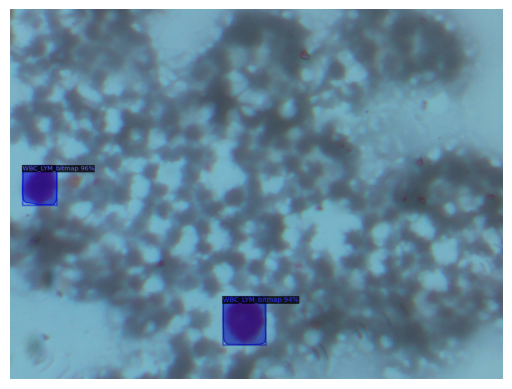

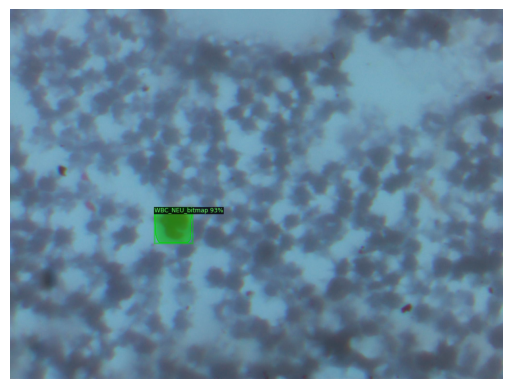

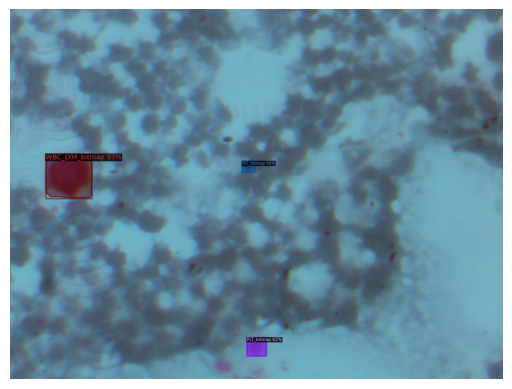

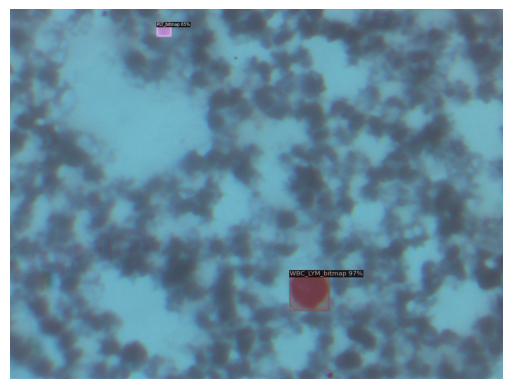

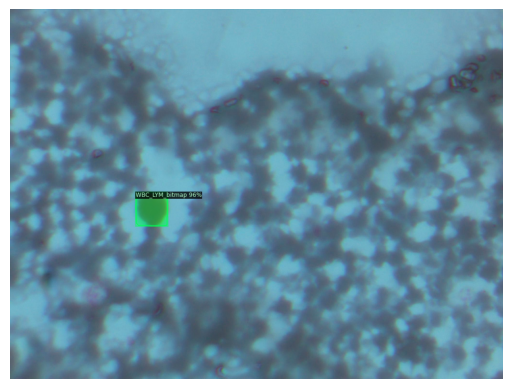

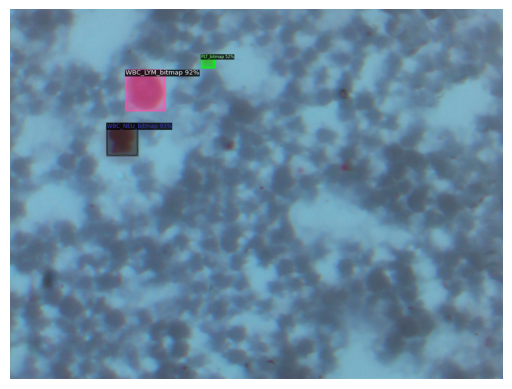

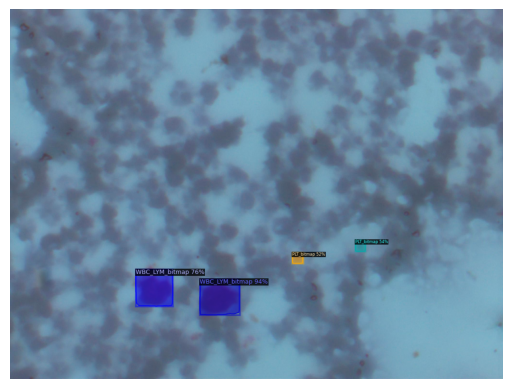

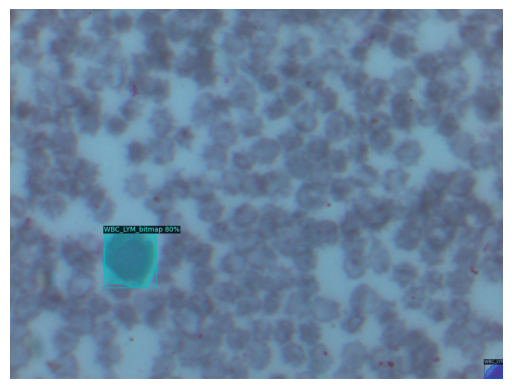

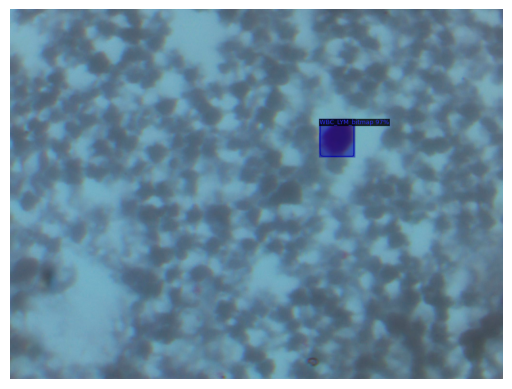

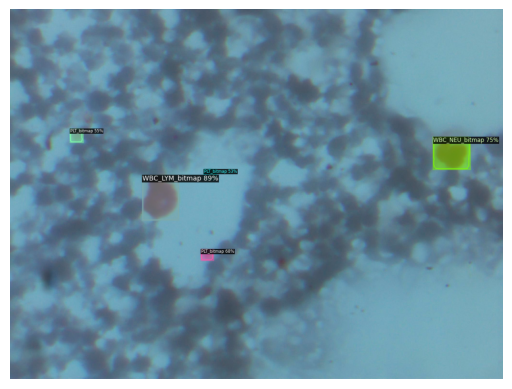

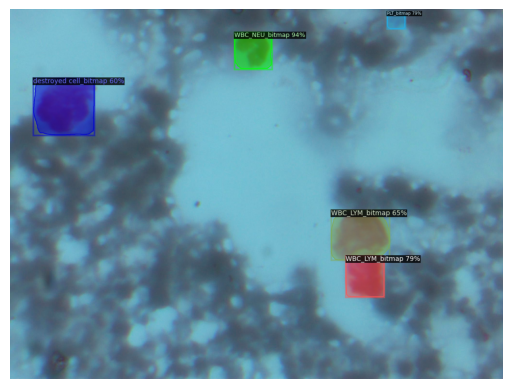

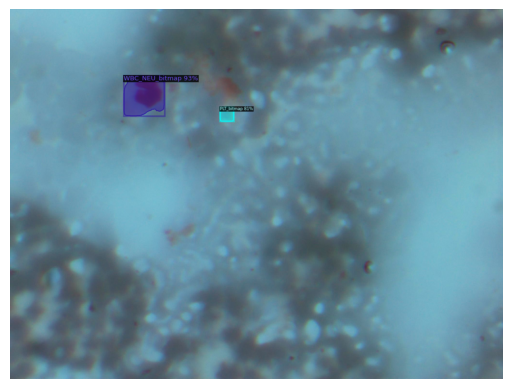

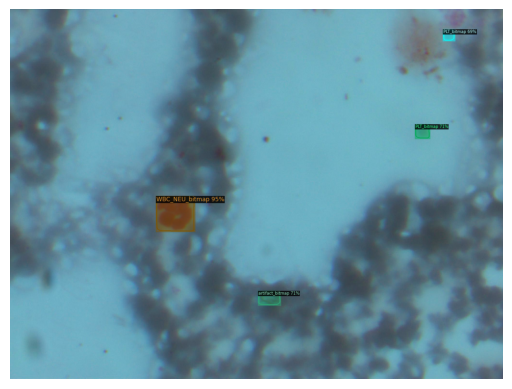

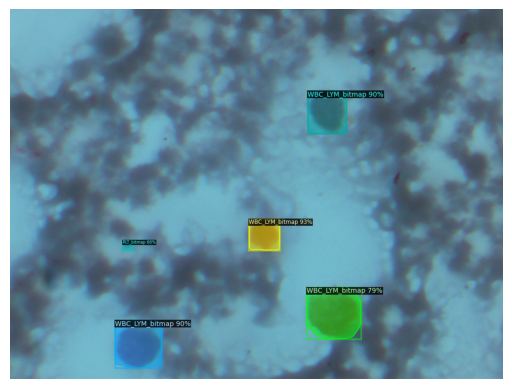

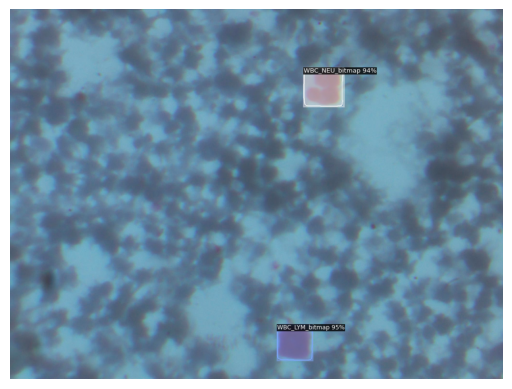

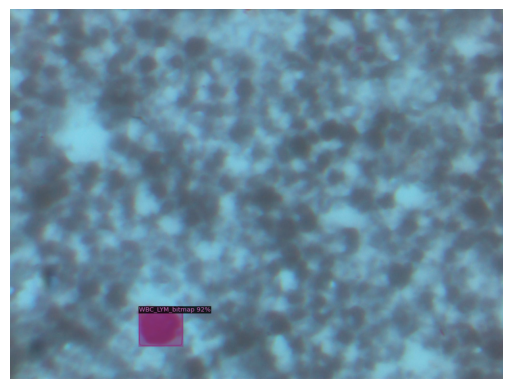

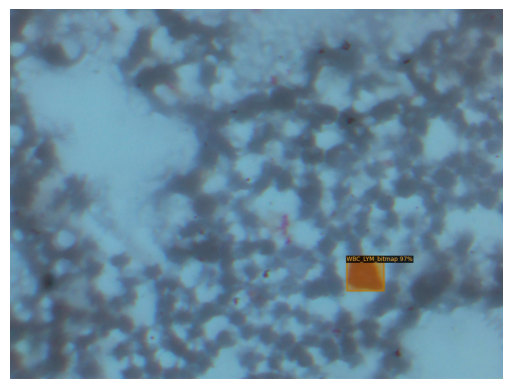

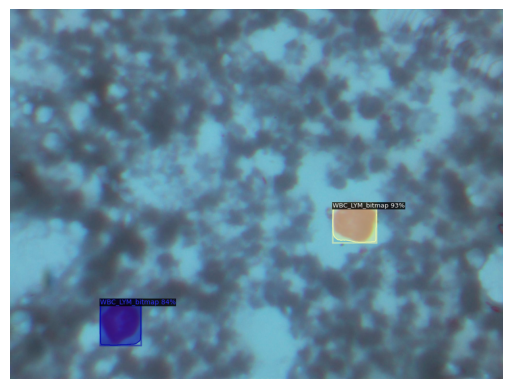

In [ ]:
dataset_dicts = dataset_test
cells_metadata = MetadataCatalog.get("blood_cells_test")
for d in random.sample(dataset_dicts, 20):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    
    v = Visualizer(im[:, :, ::-1],
                    metadata=cells_metadata, 
                    scale=0.5,               
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
    # Display the image using matplotlib
    # I have a bluish style for the picture, because differences with cv2 and plt color perception
    # Need to use plt.imshow(out.get_image())
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

## Models evaluating

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("blood_cells_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "blood_cells_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

WARNING [08/25 13:23:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/25 13:23:05 d2.data.datasets.coco]: Loaded 99 images in COCO format from ./images/test/_annotations.coco.json
[08/25 13:23:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 13:23:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 13:23:05 d2.data.common]: Serializing 99 elements to byte tensors and concatenating them all ...
[08/25 13:23:05 d2.data.common]: Serialized dataset takes 0.05 MiB
[08/25 13:23:05 d2.evaluation.evaluator]: Start inference on 99 batches
[08/25 13:23:39 d2.evaluation.evaluator]: Inference done 11/99. Dataloading: 0.0007 s/iter. Inference: 2.4127 s/iter. Eval: 0.0354 s/iter. Total: 2.4488 s/iter. ETA=0:03:35
[08/25 13:23:44 d2.evaluation.evalu

[08/25 13:27:18 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category              | AP     | category            | AP     |
|:------------------|:-------|:----------------------|:-------|:--------------------|:-------|
| BloodCells        | nan    | PLT_agregate_bitmap   | nan    | PLT_bitmap          | 8.160  |
| RBC_Normal_bitmap | nan    | WBC_BAS_bitmap        | nan    | WBC_EOS_bitmap      | 0.000  |
| WBC_LYM_bitmap    | 79.788 | WBC_MONO_bitmap       | nan    | WBC_NEU_bitmap      | 52.035 |
| artifact_bitmap   | 11.112 | destroyed cell_bitmap | 34.620 | divided cell_bitmap | 0.000  |
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[08/25 13:27:18 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[08/25 13:27:18 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[08/25 13:27:18 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[08/25 13:27:18 d2.eval

The performance of the cloud model is noticeably better than that of the other model in the model.ipynb file. By using different models and approaches, we can achieve our goal more effectively. I believe that unifying both models could enhance detection and segmentation results.